In [1]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from qdax.core.containers.mome_repertoire import MOMERepertoire
from qdax import environments
from qdax.core.neuroevolution.networks.networks import MLP
import os
from typing import List, Tuple
from IPython.display import HTML
from brax.io import html
from jax.flatten_util import ravel_pytree
from brax.io.file import File
from qdax.utils.plotting import plot_mome_pareto_fronts
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
import jax.random as jrandom
import plotly.graph_objs as go
import numpy as np
from IPython.display import HTML, clear_output
import logging
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
# Configuration
policy_hidden_layer_sizes = (64, 64)
episode_length = 1000
env_name = "kicker_multi"
fixed_init_state = False
mutation_ga_batch_size = 256
mutation_qpg_batch_size = 64
num_objective_functions = 2
num_centroids = 256
pareto_front_max_length = 20
batch_size = mutation_ga_batch_size + mutation_qpg_batch_size * num_objective_functions
friction = 0.9
height = 0.1

repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-29_143704_42/final/repertoire/"

# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/final/repertoire/"

# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-11_133538_42/final/repertoire/"
# repertoire_path = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/best_walls/final/repertoire/"
num_top_solutions = 5120
save_dir = f"/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/average_rs_2.0_dt_0.02/adaptation/friction/0.9_/"

# save_dir = f"/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-18_141316_42/adaptation/friction/{friction}/"
# save_dir = f"/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/2024-07-11_133538_42/adaptation/friction/{frict}/"
# save_dir = "/home/coder/project/MOME_PGX/results/kicker_multi/mome_pgx/best_walls/adaptation/friction/test/"

# Main parameters of M-BOA
sigma_noise_squared = 0.001
alpha = 0.9
rho = 0.8
kappa = 1

In [3]:

# Load the environment
env = environments.create(env_name, episode_length=episode_length, fixed_init_state=fixed_init_state)

# Function to visualize individual policies
def visualise_individual(env, policy_network, params, name, save_dir):
    """Roll out individual policy and save visualization."""
    path = os.path.join(save_dir, name)
    metrics_path = os.path.join(save_dir, f"{name}_metrics.json")

    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(policy_network.apply)

    rollout = []
    metrics_list = []
    rng = PRNGKey(seed=1)
    state = jit_env_reset(rng=rng)
    cumulative_reward_dist = 0.0

    while not state.done:
        rollout.append(state)
        action = jit_inference_fn(params, state.obs)
        state = jit_env_step(state, action)
        metrics_list.append({
            "reward_dist": float(state.metrics["reward_dist"]),
            "reward_ctrl": float(state.metrics["reward_ctrl"]),
            "contact_timesteps": float(state.info["contact_timesteps"])
        })
        cumulative_reward_dist += float(state.metrics["reward_dist"])

    with File(path, 'w') as fout:
        fout.write(html.render(env.sys, [s.qp for s in rollout], height=480))

    with open(metrics_path, 'w') as fout:
        json.dump(metrics_list, fout, indent=4)
    print("Dist reward", cumulative_reward_dist)

# Function to get the top x solutions from the repertoire
def get_top_1_t_solutions(repertoire, x: int) -> Tuple[List, List]:
    """Return the top x individuals with the highest fitness for the primary objective."""
    fitnesses = jnp.concatenate(repertoire.fitnesses, axis=0)
    primary_fitnesses = fitnesses[:, 0]  # Extract primary objective fitness

    top_n_indices = jnp.argsort(primary_fitnesses, axis=0)[::-1][:x]  # Get indices of top x fitness values
    top_n_fitnesses = jnp.take(primary_fitnesses, top_n_indices, axis=0)  # Get the top x fitness values

    genotypes_list = jax.tree_util.tree_map(lambda x: jnp.concatenate(x, axis=0), repertoire.genotypes)
    top_n_genotypes = [jax.tree_util.tree_map(lambda x: x[individual], genotypes_list) for individual in top_n_indices]

    return top_n_genotypes, top_n_fitnesses

# Function to plot metrics from JSON
def plot_metrics_from_json(json_path: str, save_dir: str):
    """Plot reward metrics over time from a JSON file."""
    with open(json_path, 'r') as f:
        metrics = json.load(f)

    timesteps = list(range(len(metrics)))
    reward_dist = [m['reward_dist'] for m in metrics]
    reward_ctrl = [m['reward_ctrl'] for m in metrics]

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, reward_dist, label='Reward Dist')
    plt.plot(timesteps, reward_ctrl, label='Reward Ctrl')
    plt.xlabel('Timesteps')
    plt.ylabel('Reward')
    plt.title('Reward Metrics Over Time')
    plt.legend()
    plt_path = os.path.join(save_dir, os.path.basename(json_path).replace('.json', '.pdf'))
    plt.savefig(plt_path)
    plt.close()

# Function to plot fitness from JSON
def plot_fitness_from_json(json_path: str, save_dir: str):
    """Plot cumulative fitness over time from a JSON file."""
    with open(json_path, 'r') as f:
        metrics = json.load(f)

    timesteps = list(range(len(metrics)))
    fitness_dist = []  
    fitness_ctrl = []  
    cumulative_dist = 0  
    cumulative_ctrl = 0  

    for m in metrics:
        cumulative_dist += m['reward_dist'] 
        cumulative_ctrl += m['reward_ctrl']  
        fitness_dist.append(cumulative_dist)  
        fitness_ctrl.append(cumulative_ctrl) 

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, fitness_dist, label='Reward Dist')
    plt.plot(timesteps, fitness_ctrl, label='Reward Ctrl')
    plt.xlabel('Timesteps')
    plt.ylabel('Fitness')
    plt.title('Fitnesses Over Time')
    plt.legend()
    plt_path = os.path.join(save_dir, 'fitnesses.pdf')
    plt.savefig(plt_path)
    plt.close()



# Adaptation step: Define changed environment
changed_env_name = "kicker_multi" 
changed_env = environments.create(changed_env_name, episode_length=episode_length, fixed_init_state=fixed_init_state)

# Function to evaluate a policy in the changed environment
def evaluate_in_changed_env(env, policy_network, params, seed=1) -> Tuple[float, float]:
    """Evaluate policy in the changed environment and return cumulative rewards."""
    jit_env_reset = jax.jit(env.reset)
    jit_env_step = jax.jit(env.step)
    jit_inference_fn = jax.jit(policy_network.apply)

    rng = PRNGKey(seed=seed)
    state = jit_env_reset(rng=rng)

    cumulative_reward_dist = 0.0
    cumulative_reward_ctrl = 0.0

    while not state.done:
        action = jit_inference_fn(params, state.obs)
        state = jit_env_step(state, action)
        cumulative_reward_dist += float(state.metrics["reward_dist"])
        cumulative_reward_ctrl += float(state.metrics["reward_ctrl"])

    return cumulative_reward_dist, cumulative_reward_ctrl

# Flatten and reconstruction functions for genotypes
global_unravel_fn = None

def flatten(genotype):
    """Flatten a genotype."""
    global global_unravel_fn
    flatten_genotype, unravel_fn = ravel_pytree(genotype)
    if global_unravel_fn is None:
        global_unravel_fn = unravel_fn 
    return flatten_genotype

def reconstruction_fn(flat_genotype):
    """Reconstruct a genotype from its flattened form."""
    return global_unravel_fn(flat_genotype)

# Initialize policy network
random_key = PRNGKey(42)
random_key, subkey = jax.random.split(random_key)
env = environments.create(env_name, episode_length=episode_length)
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)
random_key, subkey = jax.random.split(random_key)

keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_genotypes = jax.vmap(policy_network.init)(keys, fake_batch)

default_genotypes = jax.tree_util.tree_map(
    lambda x: jnp.zeros(
        shape=(
            num_centroids,
            pareto_front_max_length,
        ) + x.shape[1:]
    ),
    init_genotypes,
)

In [4]:
def plot_gp_offset(ax, x_map, gp_offset_sr, evaluated_descriptors, evaluated_performances, best_descriptor):
    evaluated_descriptors = np.array(evaluated_descriptors)
    evaluated_performances = np.array(evaluated_performances)
    X1, X2 = np.meshgrid(np.linspace(x_map[:, 0].min(), x_map[:, 0].max(), 100),
                         np.linspace(x_map[:, 1].min(), x_map[:, 1].max(), 100))
    X_mesh = np.column_stack((X1.ravel(), X2.ravel()))
    offset_mean, offset_std = gp_offset_sr.predict(X_mesh, return_std=True)
    mean = offset_mean.reshape(X1.shape)
    
    contour_mean = ax.contourf(X1, X2, mean, levels=100, cmap='cool', alpha=0.8)
    cbar_mean = plt.colorbar(contour_mean, ax=ax, label='Mean Prediction')

    scatter = ax.scatter(evaluated_descriptors[:, 0], evaluated_descriptors[:, 1], c=evaluated_performances, s=50, edgecolor='black', cmap='viridis', label='Evaluated Descriptors')
    plt.colorbar(scatter, ax=ax, label='Performance')
    ax.scatter(best_descriptor[0], best_descriptor[1], edgecolor='red', marker="o", facecolor='none', zorder=3, s=100, linewidth=3, label='Best Descriptor')

    ax.set_title('Offset GP Mean Predictions')
    ax.set_xlabel('Descriptor Dimension 1')
    ax.set_ylabel('Descriptor Dimension 2')
    ax.legend(loc='upper right')

def plot_gp_sr(ax, x_map, gp_sim, evaluated_descriptors, evaluated_performances, best_descriptor):
    evaluated_descriptors = np.array(evaluated_descriptors)
    evaluated_performances = np.array(evaluated_performances)
    X1, X2 = np.meshgrid(np.linspace(x_map[:, 0].min(), x_map[:, 0].max(), 100),
                         np.linspace(x_map[:, 1].min(), x_map[:, 1].max(), 100))
    X_mesh = np.column_stack((X1.ravel(), X2.ravel()))
    mean, std = gp_sim.predict(X_mesh, return_std=True)
    mean = mean.reshape(X1.shape)
    
    contour_mean = ax.contourf(X1, X2, mean, levels=100, cmap='cool', alpha=0.8)
    cbar_mean = plt.colorbar(contour_mean, ax=ax, label='Simulation Performance')
    scatter = ax.scatter(evaluated_descriptors[:, 0], evaluated_descriptors[:, 1], c=evaluated_performances, s=50, edgecolor='black', cmap='viridis', label='Evaluated Descriptors')
    plt.colorbar(scatter, ax=ax, label='Real Performance')
    ax.scatter(best_descriptor[0], best_descriptor[1], edgecolor='red', marker="o", facecolor='none', zorder=3, s=100, linewidth=3, label='Best Descriptor')

    ax.set_title('Simulation GP Mean Predictions')
    ax.set_xlabel('Descriptor Dimension 1')
    ax.set_ylabel('Descriptor Dimension 2')
    ax.legend(loc='upper right')

def plot_p(ax, eval_perf, sim_perf):
    ax.plot(range(len(eval_perf)), eval_perf, label='Evaluated Performance')
    ax.plot(range(len(sim_perf)), sim_perf, label='Performance Map Value')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Performance')
    ax.set_title('Evaluated Performances Over Iterations')
    ax.legend()

def plot_offset(ax, eval_perf, pred_offset, act_offset, sim_perf):
    # Determine the number of points to plot for pred_offset
    num_points = len(act_offset)
    
    ax.plot(range(len(eval_perf)), eval_perf, label='Evaluated Performance')
    ax.plot(range(len(sim_perf)), sim_perf, label='Predicted Performance')
    ax.plot(range(num_points), pred_offset[:num_points], 'r', linestyle='dashed', label='Predicted offset')
    ax.plot(range(len(act_offset)), act_offset, 'g', linestyle='dashed', label='Actual offset')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Performance')
    ax.set_title('Performances Over Iterations')
    ax.legend()


In [5]:
# Get the reconstruction fn
flat_genotypes = jax.vmap(flatten)(default_genotypes)

# Load the precomputed repertoire
repertoire = MOMERepertoire.load(reconstruction_fn=global_unravel_fn, path=repertoire_path)

In [10]:
# Extract behavior descriptors and fitnesses
descriptors = jnp.concatenate(repertoire.descriptors, axis=0)
fitnesses = jnp.concatenate(repertoire.fitnesses, axis=0)
primary_fitnesses = fitnesses[:, 0]  # Use primary objective fitness for selection

# Sort and select the top x solutions based on primary fitness
print("Selecting data...")
top_n_indices = jnp.argsort(primary_fitnesses, axis=0)[::-1][:num_top_solutions]
top_n_descriptors = descriptors[top_n_indices]
top_n_fitnesses = primary_fitnesses[top_n_indices]
top_n_genotypes = jax.tree_util.tree_map(lambda x: jnp.concatenate(x, axis=0), repertoire.genotypes)
top_n_genotypes = [jax.tree_util.tree_map(lambda x: x[individual], top_n_genotypes) for individual in top_n_indices]

evaluated_indices = set()
print("Cleaning data...")
valid_mask = ~jnp.isnan(top_n_descriptors).any(axis=1) & ~jnp.isinf(top_n_fitnesses) & (top_n_descriptors != 0.0).all(axis=1) 
x_map = top_n_descriptors[valid_mask]
valid_indices = jnp.nonzero(valid_mask)[0]

top_n_fitnesses_clean = top_n_fitnesses[valid_indices]
C_map = [top_n_genotypes[i] for i in valid_indices]

# Normalize descriptors to ensure diversity
print("Scaling fitnesses to create P_map_sim...")
scaler_fitness = StandardScaler()
P_map_sim = scaler_fitness.fit_transform(np.array(top_n_fitnesses_clean).reshape(-1, 1)).flatten()

Selecting data...
Cleaning data...


TypeError: unhashable type: 'DeviceArray'

In [9]:
adapted_results = []

In [10]:
# Gaussian Process setup
print("Setting up GPs...")
kernel = C(1.0, (1e-3, 1e1)) * Matern(length_scale=rho, nu=2.5) + WhiteKernel(noise_level=sigma_noise_squared)
gp_offset_sr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

Setting up GPs...


In [11]:
mean_prior = max(P_map_sim)
variance_prior = 1

diff/sigma > 3

In [12]:
file_dir = os.path.join(save_dir, "logs")
save_log = os.path.join(file_dir, "bayesian_optimization.log")
os.makedirs(file_dir, exist_ok=True)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler(save_log)
console_handler = logging.StreamHandler()

file_handler.setLevel(logging.INFO)
console_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

logger.addHandler(file_handler)
logger.addHandler(console_handler)

In [13]:
def bayesian_optimization_adaptation(P_map_sim, x_map, changed_env, policy_network, num_iterations, alpha, kappa, sigma_noise_squared, gp_offset_sr, scaler_fitness):
    logger.info("Starting Bayesian Optimization adaptation process...")

    # Initial performance threshold
    performance_threshold = (max(P_map_sim)-min(P_map_sim))*alpha + min(P_map_sim)
    logger.info(f"Initial performance threshold: {performance_threshold}")

    # Initial expected performance
    max_expected_performance = max(P_map_sim)
    training_indices = []
    sr_offset = []
    evaluated_descriptors = []
    evaluated_performances = []
    P_1_t = [] # observations list
    P_X_1_t = [] # simulation performance list
    best_sol = []
    k=[]

    # Perform initial predictions to generate data for the GP for simulation-reality offset

    ucb = mean_prior + variance_prior * kappa
    idx = int(jnp.argmax(ucb))

    logger.info(f"Initial evaluation of descriptor {idx}")
    cumulative_reward_dist, cumulative_reward_ctrl = evaluate_in_changed_env(changed_env, policy_network, C_map[idx])
    evaluated_performances.append(cumulative_reward_dist)
    P_real_scaled = scaler_fitness.transform(jnp.array([[cumulative_reward_dist]])).flatten()[0]
    P_X_1_t.append(P_map_sim[idx])
    P_1_t.append(P_real_scaled)
    # sr_offset.append(diff)
    adapted_results.append((idx, cumulative_reward_dist, cumulative_reward_ctrl))
    training_indices.append(idx)
    evaluated_descriptors.append(x_map[idx])
    best_sol.append(P_real_scaled)
    diff = np.array(P_1_t) - np.array(P_X_1_t)
    k.append(kappa)


    # Initialize lists to store the data for plotting
    
    # Start the main loop
    for iteration in range(num_iterations):
        logger.info(f"\nIteration {iteration}...")

        P_x = P_map_sim[idx]
        logger.info(f'{evaluated_performances=}')
        logger.info(f'{P_1_t=}')
        logger.info(f'{evaluated_descriptors=}')
        logger.info(f'{diff=}')
        gp_offset_sr.fit(np.array(evaluated_descriptors), diff)

        mu_offset, sigma_offset = gp_offset_sr.predict(x_map, return_std=True)
        logger.info(f'{mu_offset[:len(evaluated_descriptors)]=}')

        mu = P_map_sim + mu_offset
        sigma = sigma_offset 
        logger.info(f'{P_x=}')

        ucb = mu + sigma * kappa

        # Select the next descriptor to evaluate
        idx = int(jnp.argmax(ucb))

        # Ensure we do not evaluate the same descriptor again
        while idx in training_indices:
            ucb = jnp.where(ucb == ucb[idx], -jnp.inf, ucb)
            idx = int(jnp.argmax(ucb))
        
        logger.info(f"Evaluating descriptor {idx}")
        cumulative_reward_dist, cumulative_reward_ctrl = evaluate_in_changed_env(changed_env, policy_network, C_map[idx])
        logger.info(f"Evaluation result: [{cumulative_reward_dist}, {cumulative_reward_ctrl}]")
        P_real_scaled = scaler_fitness.transform(jnp.array([[cumulative_reward_dist]])).flatten()[0]
        
        P_sim_scaled = P_map_sim[idx]
        P_X_1_t.append(P_sim_scaled)
        P_1_t.append(P_real_scaled)
        #sr_offset.append(P_real_scaled - P_sim_scaled)
        adapted_results.append((idx, cumulative_reward_dist, cumulative_reward_ctrl))
        training_indices.append(idx)
        evaluated_descriptors.append(x_map[idx])
        evaluated_performances.append(cumulative_reward_dist)
        diff = np.array(P_1_t) - np.array(P_X_1_t)
        k.append(kappa)
        
        best_index = np.argmax(evaluated_performances)
        best_descriptor = evaluated_descriptors[best_index]
        best_sol.append(max(P_1_t))

        current_best_performance = max([result[1] for result in adapted_results])
        logger.info(f"Current best reward_dist: {current_best_performance}")
        if P_real_scaled > performance_threshold:
            kappa = 0.03
        logger.info(f"kappa={kappa}")
        fig, axes = plt.subplots(1, 2, figsize=(30, 12))

        plot_gp_offset(axes[0], x_map, gp_offset_sr, evaluated_descriptors, P_1_t, best_descriptor)
        #plot_gp_sr(axes[1], x_map, gp_sim, evaluated_descriptors, P_1_t, best_descriptor)
        #plot_p(axes[2], P_1_t, p_sim)
        plot_offset(axes[1], P_1_t, mu_offset, diff, P_X_1_t)

        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
        
    logger.info("Adaptation process complete.")

    return adapted_results, gp_offset_sr, evaluated_descriptors, P_1_t, evaluated_performances, diff, best_sol, k

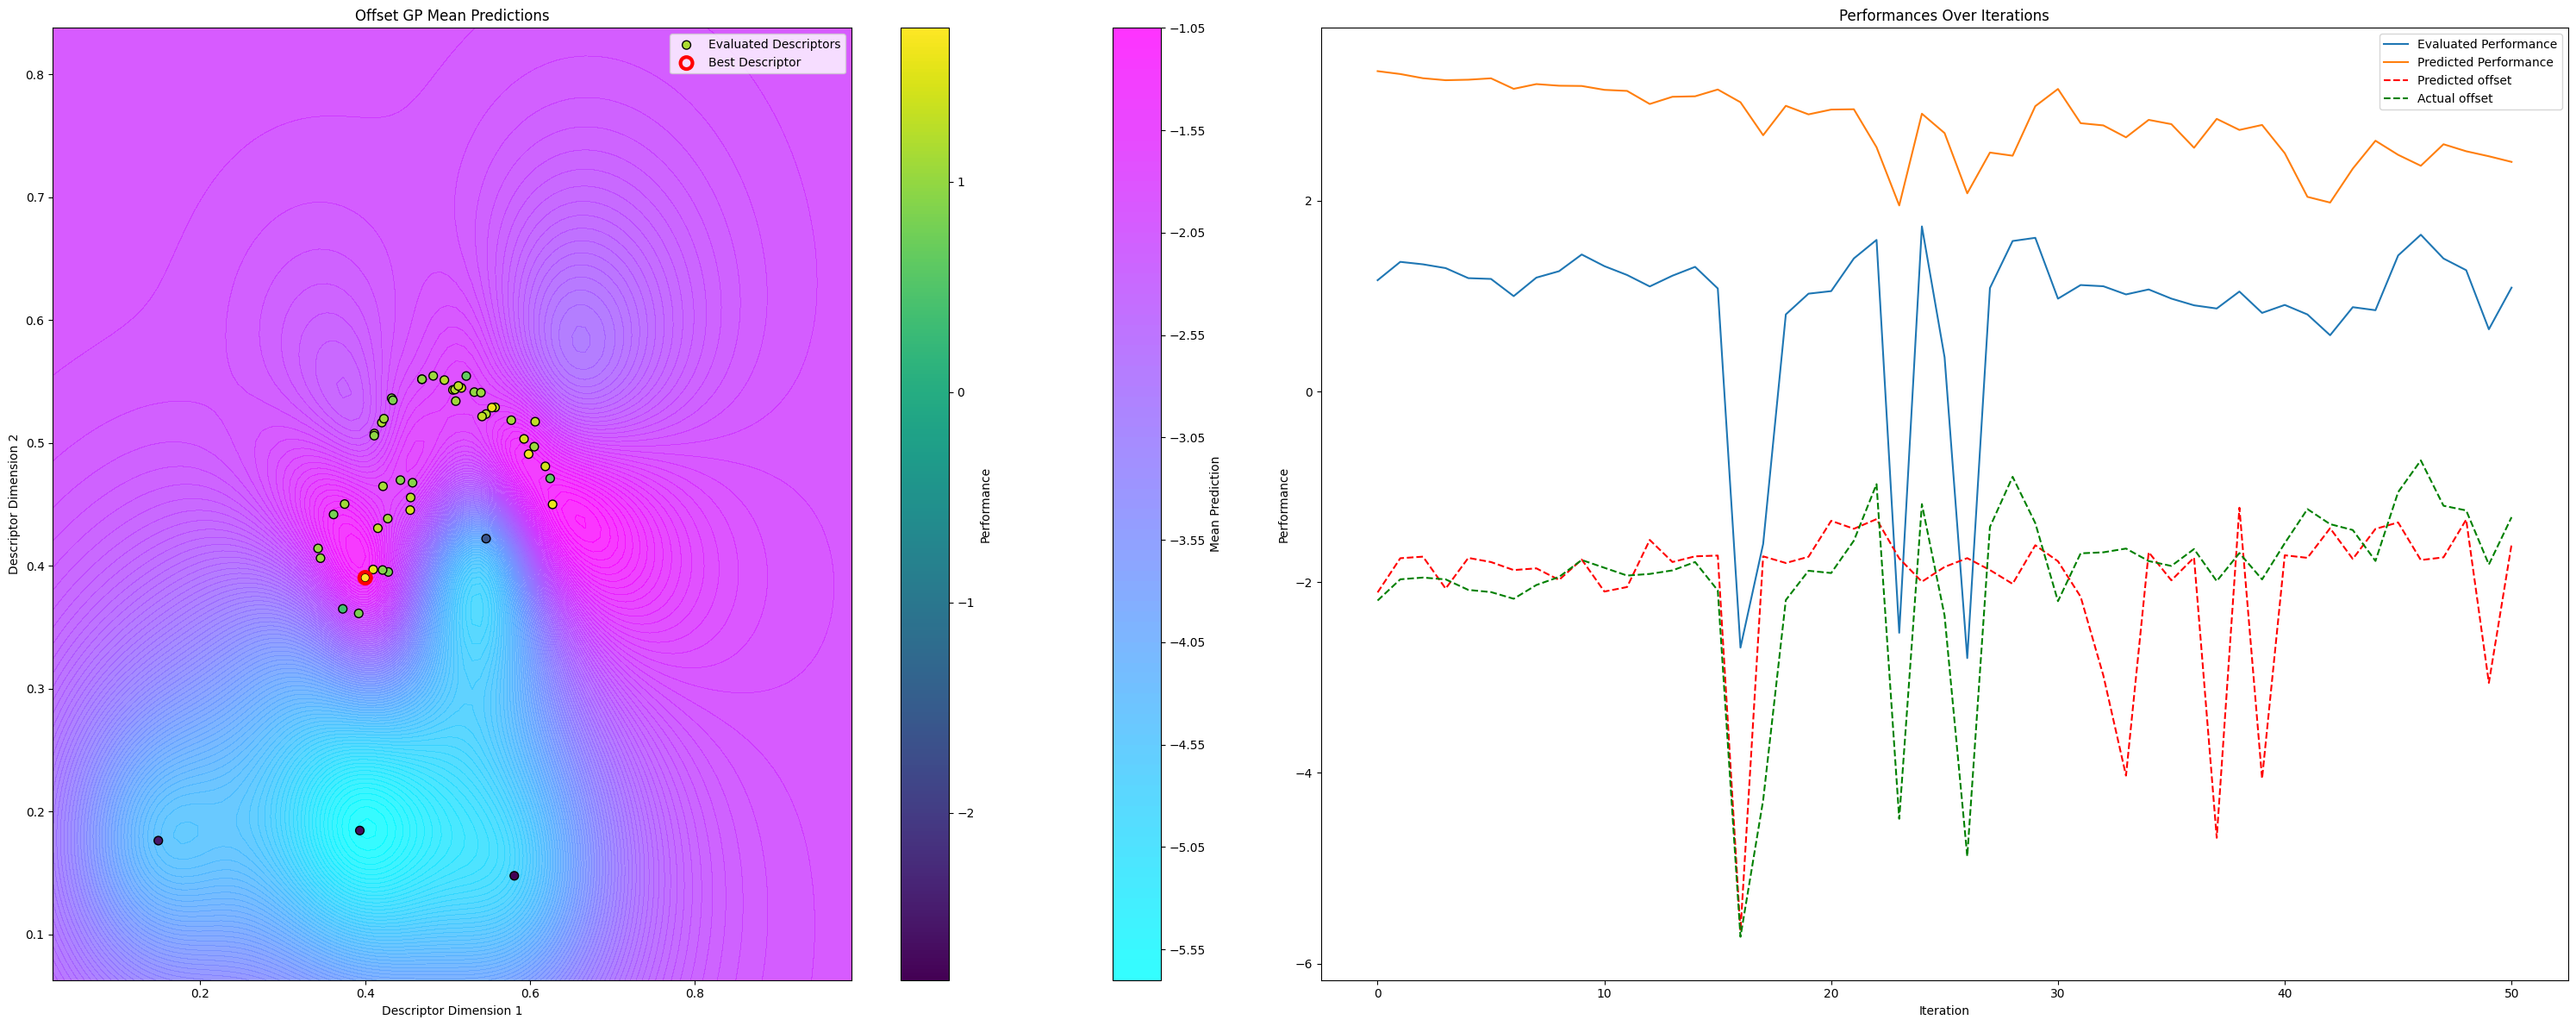

2024-08-04 15:33:19,401 - INFO - Adaptation process complete.
INFO:__main__:Adaptation process complete.


In [14]:
# Perform the adaptation using Bayesian Optimization
adapted_results, gp_offset_sr, evaluated_descriptors, evaluated_performances, evaluated_performances_original, y_offset, best_sol, k = bayesian_optimization_adaptation(
    P_map_sim, x_map, changed_env, policy_network, num_iterations=50, alpha=alpha, kappa=kappa, sigma_noise_squared=sigma_noise_squared, gp_offset_sr=gp_offset_sr, scaler_fitness=scaler_fitness
)

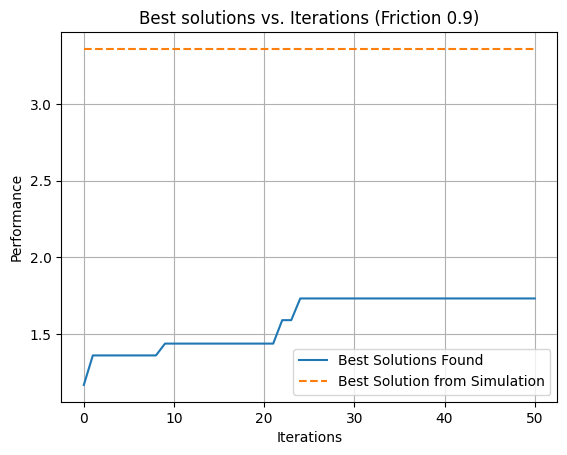

In [15]:
plt.plot(best_sol, label='Best Solutions Found')
plt.plot([i for i in range(len(best_sol))], [max(P_map_sim) for _ in range(len(best_sol))], linestyle="dashed", label='Best Solution from Simulation')
# plt.plot(evaluated_performances)
# plt.plot(k, linestyle="dashed", label="Kappa Parameter")
plt.title(f'Best solutions vs. Iterations (Friction {friction})')
plt.xlabel("Iterations")
plt.ylabel('Performance')
plt.grid()
plt.legend()
plt.savefig(os.path.join(save_dir, 'best_perf_evolution.pdf'))
plt.show()

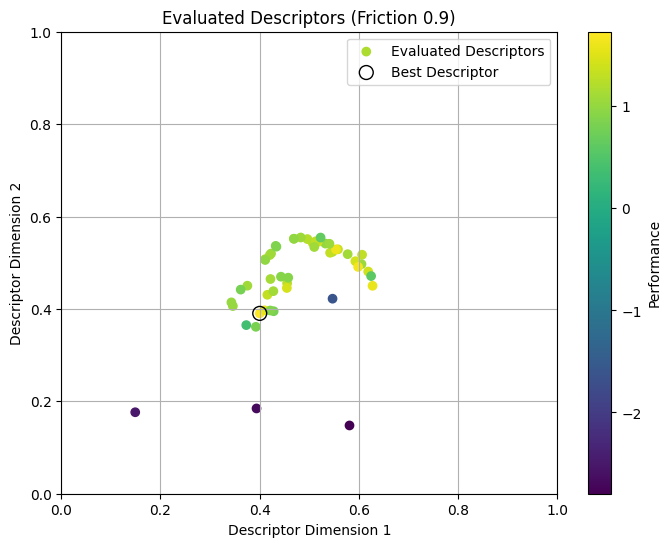

In [16]:
# Plot the evaluated descriptors
evaluated_descriptors = np.array(evaluated_descriptors)
X_offset = evaluated_descriptors
evaluated_performances = np.array(evaluated_performances)
best_index = np.argmax(evaluated_performances)
best_descriptor = evaluated_descriptors[best_index]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(evaluated_descriptors[:, 0], evaluated_descriptors[:, 1], c=evaluated_performances, cmap='viridis', label='Evaluated Descriptors')
plt.colorbar(scatter, label='Performance')
plt.scatter(best_descriptor[0], best_descriptor[1], edgecolor='black', marker="o", facecolor='none', zorder=3, s=100, linewidth=1, label='Best Descriptor')
plt.xlabel('Descriptor Dimension 1')
plt.ylabel('Descriptor Dimension 2')
plt.title(f'Evaluated Descriptors (Friction {friction})')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt_path = os.path.join(save_dir, 'evaluated_descriptors.pdf')
plt.show()

Offset mean range: -5.663011290566684 to -1.0953248065332897


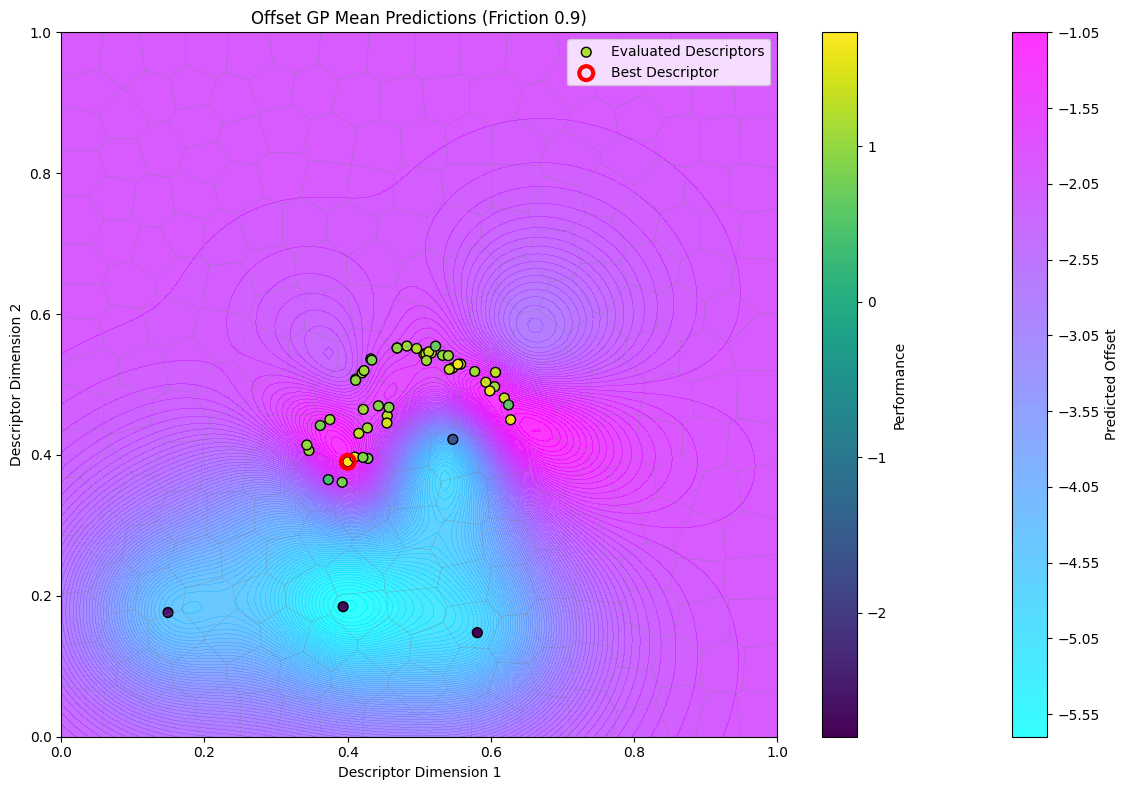

In [17]:
centroids = repertoire.centroids
# Create a mesh grid of points to plot the GP
X1, X2 = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_mesh = np.column_stack((X1.ravel(), X2.ravel()))

# Predict the offset mean and standard deviation at the mesh points
offset_mean, offset_std = gp_offset_sr.predict(X_mesh, return_std=True)
mean = offset_mean.reshape(X1.shape)
sigma = offset_std.reshape(X1.shape)

# Print the range of offset_mean values
print(f"Offset mean range: {offset_mean.min()} to {offset_mean.max()}")

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean predictions as filled contour plot
contour_mean = ax.contourf(X1, X2, mean, levels=100, cmap='cool', alpha=0.8)

cbar_mean = fig.colorbar(contour_mean, ax=ax, label='Predicted Offset')
# Plot the Voronoi diagram
vor = Voronoi(centroids)
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='gray', line_width=0.2)

# Plot the evaluated points
scatter = ax.scatter(evaluated_descriptors[:, 0], evaluated_descriptors[:, 1], c=evaluated_performances, s=50, edgecolor='black', cmap='viridis', label='Evaluated Descriptors')
cbar_performance = plt.colorbar(scatter, ax=ax, label='Performance')

ax.scatter(best_descriptor[0], best_descriptor[1], edgecolor='red', marker="o", facecolor='none', zorder=3, s=100, linewidth=3, label='Best Descriptor')



ax.set_title(f'Offset GP Mean Predictions (Friction {friction})')
ax.set_xlabel('Descriptor Dimension 1')
ax.set_ylabel('Descriptor Dimension 2')
ax.legend(loc='upper right')

# Set static axes limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'omp_with_voronoi.pdf'))
plt.show()

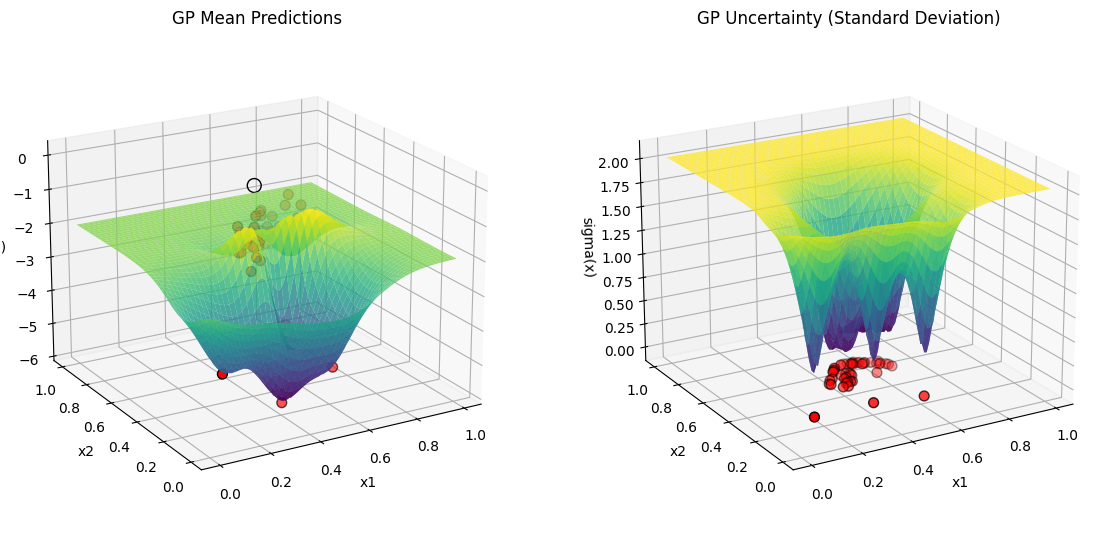

In [18]:
# Plot the results
fig = plt.figure(figsize=(14, 7))


# Plot the mean predictions
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X1, X2, mean, cmap='viridis', alpha=0.8)
ax.scatter(X_offset[:, 0], X_offset[:, 1], y_offset, c='r', s=50, zorder=10, edgecolors='k')
ax.scatter(best_descriptor[0], best_descriptor[1], edgecolor='black', marker="o", facecolor='none', zorder=3, s=100, linewidth=1, label='Best Descriptor')

ax.set_title('GP Mean Predictions')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')
ax.view_init(elev=20, azim=240)

# Plot the uncertainty
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X1, X2, sigma, cmap='viridis', alpha=0.8)
ax.scatter(X_offset[:, 0], X_offset[:, 1], np.zeros_like(y_offset), c='r', s=50, zorder=10, edgecolors='k')
ax.set_title('GP Uncertainty (Standard Deviation)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('sigma(x)')
ax.view_init(elev=20, azim=240)

plt.savefig(os.path.join(save_dir, '3D_pred.pdf'))
plt.show()

In [22]:
serializable_variables = {
    "evaluated_descriptors": np.array(evaluated_descriptors).tolist(),  
    "evaluated_performances": np.array(evaluated_performances).tolist(),  
    "evaluated_performances_original": evaluated_performances_original,
    "X_offset": np.array(X_offset).tolist(),  
    "y_offset": np.array(y_offset).tolist(),  
    "best_sol": [float(x) for x in best_sol],  
    "offset_mean": np.array(offset_mean).tolist(),  
    "offset_std": np.array(offset_std).tolist(),  
    "best_index": int(best_index)  
}
variables_path = os.path.join(save_dir, "var.json")

with open(variables_path, 'w') as fout:
    json.dump(serializable_variables, fout, indent=4)